In [1]:
using AutomotiveDrivingModels
using AutoViz
using Plots

┌ Info: Recompiling stale cache file /home/raunak/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [2]:
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

append_to_curve! (generic function with 1 method)

In [3]:
function get_track()

#     x_coods = path_info[:,3]
#     y_coods = path_info[:,4]
    x_coods = [0., 5.]
    y_coods = [3., 3.]
    theta = [0., 0.]
    turn_length = 10
    new_theta = 0.
    incremental_angle = (pi/4) / turn_length
    radius = 1
    for i = 1:turn_length
        push!(theta, new_theta)
        push!(x_coods, x_coods[end] + radius * cos(new_theta))
        push!(y_coods, y_coods[end] + radius * sin(new_theta))
        new_theta -= (incremental_angle)
    end
#     plot(x_coods, y_coods)
    mid_coods = vcat(x_coods', y_coods', theta') # x coods in first row, y coods in second row, theta in third row
    
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    curve_radius = incremental_angle
    nsamples = 1000
    for i = 3:turn_length+2
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, curve_radius, curve_radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

get_track (generic function with 1 method)

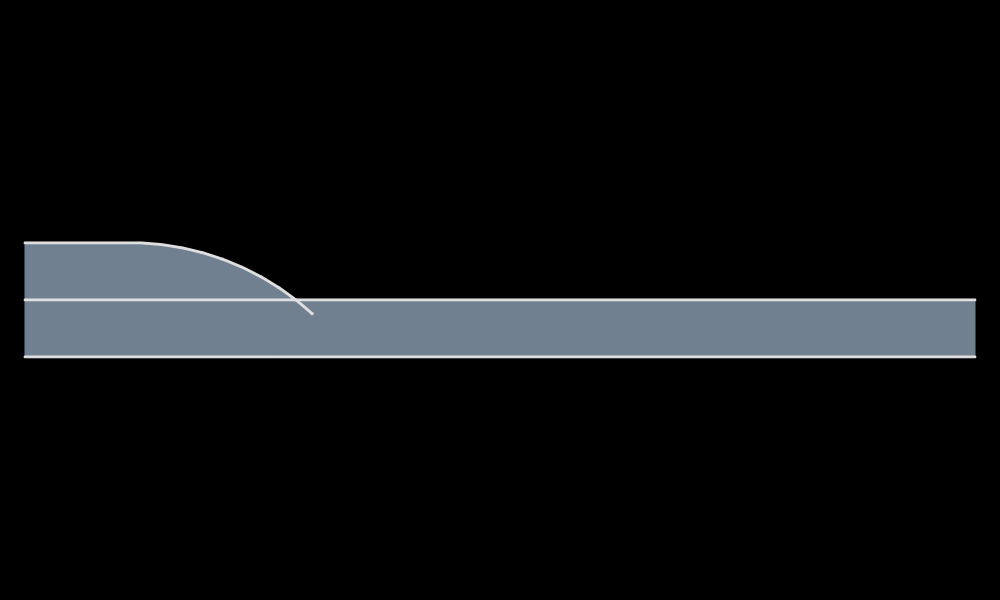

In [4]:
nlanes = 1
length = 50.
width = DEFAULT_LANE_WIDTH
roadway = gen_straight_roadway(nlanes, length)
# roadway = Roadway()

track = get_track()

lane = Lane(LaneTag(1, 2), track, width=DEFAULT_LANE_WIDTH)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))
cam = FitToContentCamera(0.05)
render(roadway, cam=cam)

In [ ]:
@show roadway.segments[1].lanes

In [ ]:
function append_headings(coordinates::Matrix{Float64})
    headings = ones(size(coordinates)[1])
    for i = 1:size(coordinates)[1]-1
        # need to make sure that math is right, and that bounds are kept
        tangent_vector = [coordinates[i+1,1]-coordinates[i,1], coordinates[i+1,2]-coordinates[i,2]]
        # @show tangent_vector
        current_heading = get_new_angle(tangent_vector)
        # @show current_heading
        headings[i] = current_heading
    end
    headings[end] = headings[end-1] # assume this is fine
    coordinates = hcat(coordinates, headings)
    return coordinates
end

In [ ]:
function get_new_angle(tangent_vector::Array{Float64})
    # it might be a problem when we switch quadrants
    # use signs of tangent vector to get the quadrant of the heading 
    x = tangent_vector[1]
    y = tangent_vector[2]
    if x == 0. && y == 0.
        heading = 0.0
    elseif x == 0.
        heading = π/2 * sign(y) 
    elseif y == 0.
        heading = convert(Float64, π) # this could be either pi or -pi, but just go with pi
    elseif sign(x) == 1 && sign(y) == 1 # first quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == 1 # second quadrant
        heading = atan(y, x)
    elseif sign(x) == 1 && sign(y) == -1 # fourth quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == -1 # third quadrant
        heading = atan(y, x)
    end
    # bound_heading doesn't end up getting called cause Julia takes care of it apparently
    bound_heading(heading)

    return heading
end

In [ ]:
function bound_heading(heading::Float64)
    if heading > π # send this to be just near -pi
        heading = -π + (heading - π)    # if heading is 3.15, then the new angle will be (-pi + (3.15-pi)) = -3.13
    elseif heading < -π # send this to be just near pi 
        heading = π + (heading + π)     # if heading is -3.15, then the new angle will be (pi + (-3.15+pi)) = 3.13
    end
    return heading
end